In [6]:

import os, os.path, sys, math
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.15.0


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [9]:
import os

data_dir = '/content/drive/MyDrive/AutoPort_Ops_ds'
classes = os.listdir(data_dir)

filenames = []
labels = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    class_files = os.listdir(class_dir)
    filenames.extend([os.path.join(class_dir, file) for file in class_files])
    labels.extend([class_name] * len(class_files))

In [10]:
print(class_dir)
print(filenames)

/content/drive/MyDrive/AutoPort_Ops_ds/inflatable_boat
['/content/drive/MyDrive/AutoPort_Ops_ds/buoy/12.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/42.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/38.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/10.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/1.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/28.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/35.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/21.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/24.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/41.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/44.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/4.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/26.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/14.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/48.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/27.jpg', '/content/drive/MyDrive/AutoPort_Ops_ds/buoy/47.jpg', '/content/drive/MyDrive/Auto

In [11]:
#data_dir = Path('AutoPort_Ops_ds')
img_height, img_width = 224, 224
batch_size = 32

# Split the data into training and testing sets
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(
    filenames,
    labels,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# Create dataframes for training and testing data
train_df = pd.DataFrame({
    'filename': X_train_filenames,
    'class': y_train
})

test_df = pd.DataFrame({
    'filename': X_test_filenames,
    'class': y_test
})

datagen = ImageDataGenerator(rescale=1./255)




In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Create generators for training and testing data
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = data_dir,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Specify class_mode as 'categorical'
    shuffle=True,              # Specify shuffling
    seed=42                    # Specify random state
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Specify class_mode as 'categorical'
    shuffle=False              # No shuffling needed for testing data
)

Found 848 validated image filenames belonging to 9 classes.
Found 212 validated image filenames belonging to 9 classes.


In [14]:
print(train_df.head())

                                            filename            class
0  /content/drive/MyDrive/AutoPort_Ops_ds/cruise_...      cruise_ship
1  /content/drive/MyDrive/AutoPort_Ops_ds/buoy/30...             buoy
2  /content/drive/MyDrive/AutoPort_Ops_ds/ferry_b...       ferry_boat
3  /content/drive/MyDrive/AutoPort_Ops_ds/cruise_...      cruise_ship
4  /content/drive/MyDrive/AutoPort_Ops_ds/inflata...  inflatable_boat


In [17]:
#selecting ResNet50 as the base model

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

#setting base model trainable to false to maintain its weights
base_model.trainable = False

#defining a sequntial neural net with specs per assignement instructions
model = Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='SAME'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu',padding='SAME'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
], name='ResNet50')



94765736/94765736 [==============================] - 1s 0us/step


In [18]:
#checking base model input and output shapes

base_model_input_shape = base_model.input_shape
print(f"Base model input shape: {base_model_input_shape}")

base_model_output_shape = base_model.output_shape
print(f"Base model output shape: {base_model_output_shape}")

Base model input shape: (None, 224, 224, 3)
Base model output shape: (None, 7, 7, 2048)


In [19]:
#importing necessary statistical calcs from keras

from tensorflow.keras.metrics import Precision, Recall

#defining the model optimizer, loss function, and statsistics it is to be evaluated on
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy', Precision(), Recall()])
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 32)          0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0  

In [20]:
#defining early stopping parameters.  This was not a part of the assignement;
#however, my thought was to avoid overfitting

early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True)
# early stopping call back


In [34]:
#defining

batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

if train_generator is not None:
    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=test_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=20,
                        callbacks=[early]
    )
else:
    print("train_generator is None. Please check the data.")


Epoch 1/20
26/26 [==============================] - 11s 438ms/step - loss: 0.1231 - accuracy: 0.9632 - precision_1: 0.9738 - recall_1: 0.9559 - val_loss: 0.5597 - val_accuracy: 0.8385 - val_precision_1: 0.8667 - val_recall_1: 0.8125
Epoch 2/20
26/26 [==============================] - 11s 414ms/step - loss: 0.0997 - accuracy: 0.9772 - precision_1: 0.9841 - recall_1: 0.9663 - val_loss: 0.5579 - val_accuracy: 0.8594 - val_precision_1: 0.8804 - val_recall_1: 0.8438
Epoch 3/20
26/26 [==============================] - 12s 483ms/step - loss: 0.0958 - accuracy: 0.9730 - precision_1: 0.9765 - recall_1: 0.9657 - val_loss: 0.5151 - val_accuracy: 0.8542 - val_precision_1: 0.8736 - val_recall_1: 0.8281
Epoch 4/20
26/26 [==============================] - 10s 385ms/step - loss: 0.0683 - accuracy: 0.9779 - precision_1: 0.9814 - recall_1: 0.9706 - val_loss: 0.5750 - val_accuracy: 0.8229 - val_precision_1: 0.8579 - val_recall_1: 0.8177
Epoch 5/20
26/26 [==============================] - 10s 396ms/step -

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:\t0.9914215803146362\nValidation Accuracy: 0.84375')

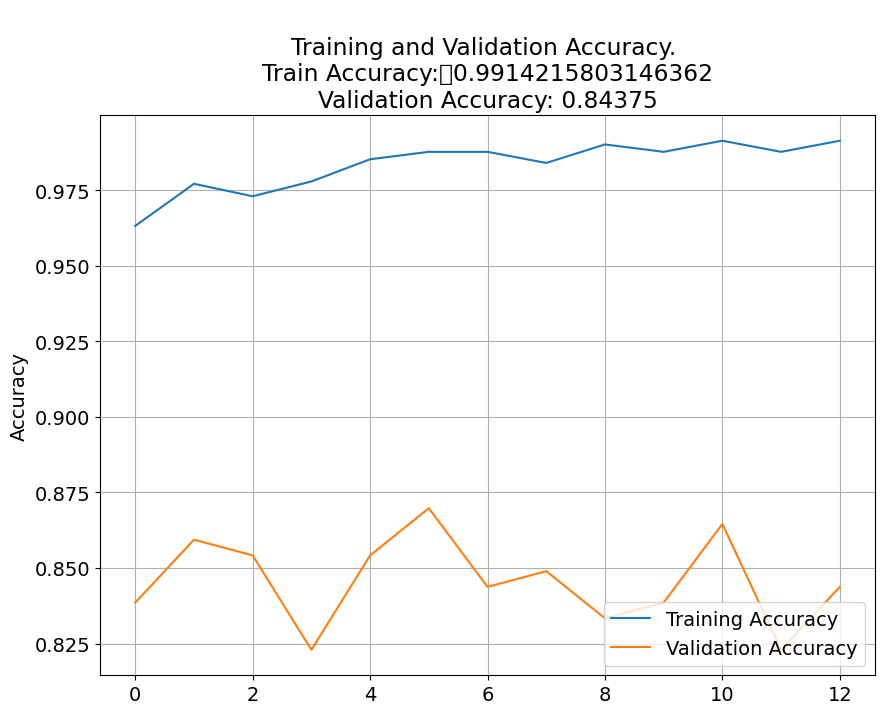

In [35]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:	{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


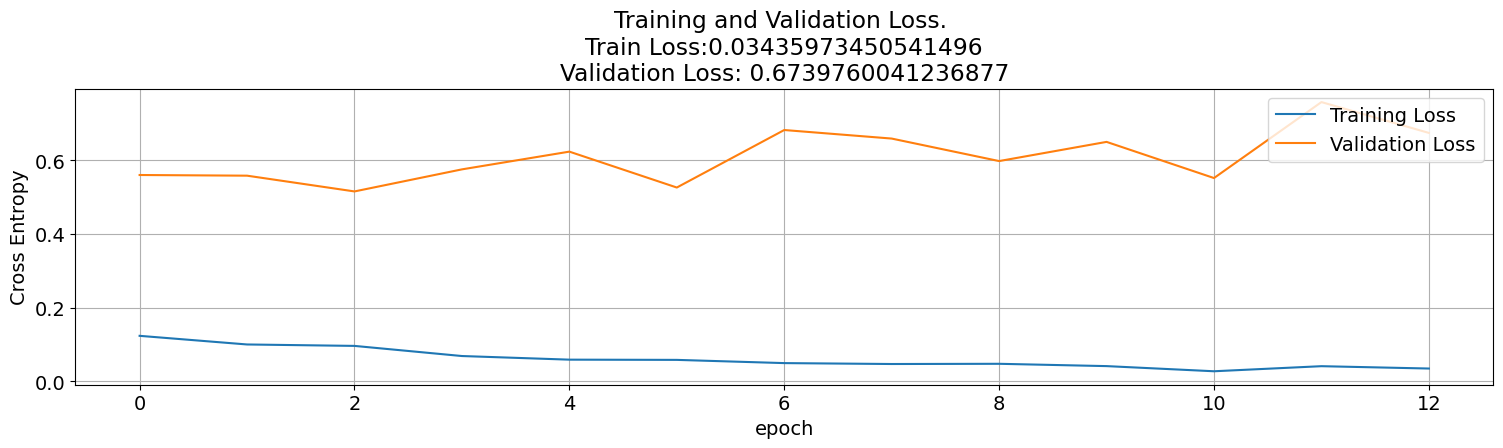

In [36]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [37]:
accuracy_score = model.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


7/7 [==============================] - 2s 299ms/step - loss: 0.4941 - accuracy: 0.8585 - precision_1: 0.8806 - recall_1: 0.8349
[0.49408960342407227, 0.8584905862808228, 0.8805969953536987, 0.8349056839942932]
Accuracy: 85.8491%
Loss:  0.49408960342407227


## **Evaluating ResNeET50 model against test image set**

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

if test_generator is not None:
    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=test_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=20,
                        callbacks=[early]
    )
else:
    print("train_generator is None. Please check the data.")


Epoch 1/20
26/26 [==============================] - 11s 438ms/step - loss: 0.1231 - accuracy: 0.9632 - precision_1: 0.9738 - recall_1: 0.9559 - val_loss: 0.5597 - val_accuracy: 0.8385 - val_precision_1: 0.8667 - val_recall_1: 0.8125
Epoch 2/20
26/26 [==============================] - 11s 414ms/step - loss: 0.0997 - accuracy: 0.9772 - precision_1: 0.9841 - recall_1: 0.9663 - val_loss: 0.5579 - val_accuracy: 0.8594 - val_precision_1: 0.8804 - val_recall_1: 0.8438
Epoch 3/20
26/26 [==============================] - 12s 483ms/step - loss: 0.0958 - accuracy: 0.9730 - precision_1: 0.9765 - recall_1: 0.9657 - val_loss: 0.5151 - val_accuracy: 0.8542 - val_precision_1: 0.8736 - val_recall_1: 0.8281
Epoch 4/20
26/26 [==============================] - 10s 385ms/step - loss: 0.0683 - accuracy: 0.9779 - precision_1: 0.9814 - recall_1: 0.9706 - val_loss: 0.5750 - val_accuracy: 0.8229 - val_precision_1: 0.8579 - val_recall_1: 0.8177
Epoch 5/20
26/26 [==============================] - 10s 396ms/step -

## **MobileNetV2**

In [25]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(9, activation='softmax'),
], name='MobileNetV2')



9406464/9406464 [==============================] - 0s 0us/step


In [26]:
base_model_input_shape = base_model.input_shape
print(f"Base model input shape: {base_model_input_shape}")

base_model_output_shape = base_model.output_shape
print(f"Base model output shape: {base_model_output_shape}")

Base model input shape: (None, 224, 224, 3)
Base model output shape: (None, 7, 7, 1280)


In [27]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy', Precision(), Recall()])
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                       

In [28]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True)
# early stopping call back


In [29]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

if train_generator is not None:
    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=test_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=20,
                        callbacks=[early]
    )
else:
    print("train_generator is None. Please check the data.")


Epoch 1/20
26/26 [==============================] - 20s 464ms/step - loss: 1.2746 - accuracy: 0.6140 - precision_1: 0.7726 - recall_1: 0.5245 - val_loss: 0.8986 - val_accuracy: 0.7292 - val_precision_1: 0.8943 - val_recall_1: 0.5729
Epoch 2/20
26/26 [==============================] - 10s 376ms/step - loss: 0.4282 - accuracy: 0.8664 - precision_1: 0.9211 - recall_1: 0.8015 - val_loss: 0.6165 - val_accuracy: 0.8125 - val_precision_1: 0.9211 - val_recall_1: 0.7292
Epoch 3/20
26/26 [==============================] - 10s 398ms/step - loss: 0.3167 - accuracy: 0.8983 - precision_1: 0.9281 - recall_1: 0.8701 - val_loss: 0.5281 - val_accuracy: 0.8333 - val_precision_1: 0.9000 - val_recall_1: 0.7969
Epoch 4/20
26/26 [==============================] - 11s 416ms/step - loss: 0.2111 - accuracy: 0.9387 - precision_1: 0.9516 - recall_1: 0.9154 - val_loss: 0.5213 - val_accuracy: 0.8594 - val_precision_1: 0.9012 - val_recall_1: 0.8073
Epoch 5/20
26/26 [==============================] - 10s 404ms/step -

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:\t0.9852941036224365\nValidation Accuracy: 0.8177083134651184')

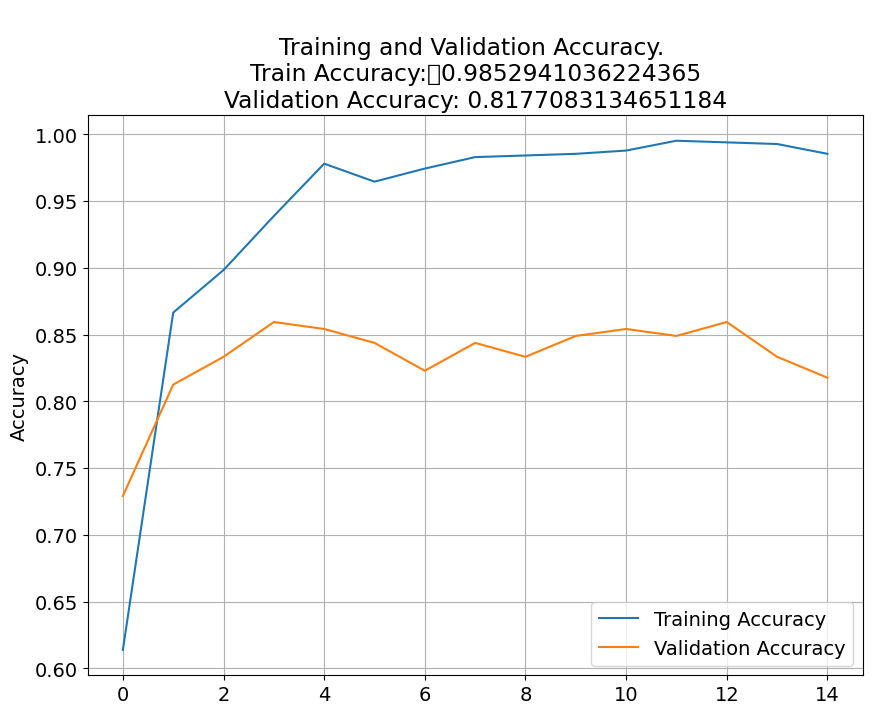

In [30]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:	{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


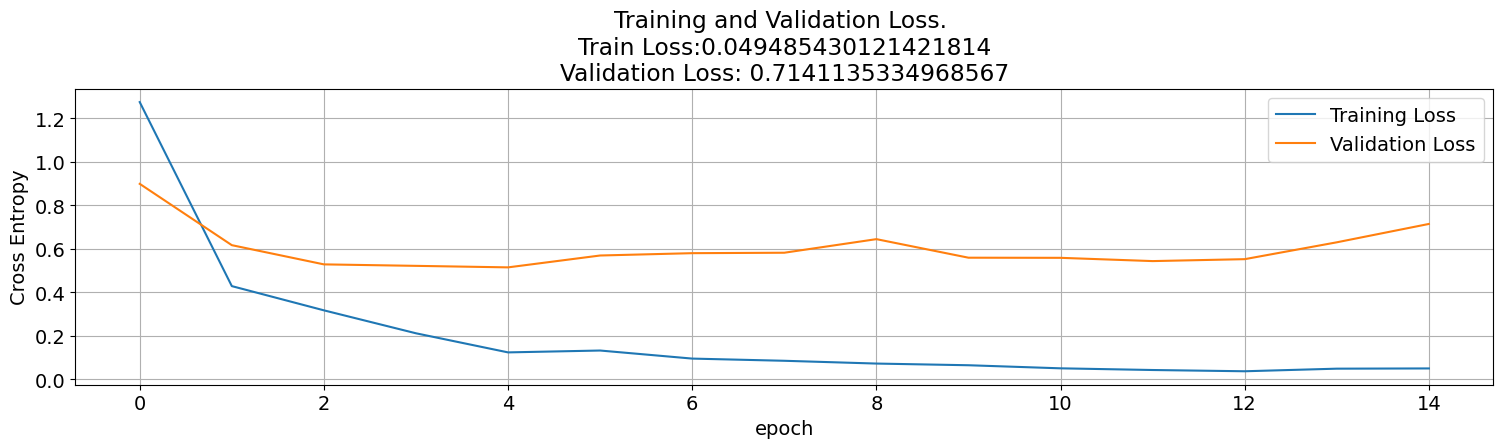

In [31]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [32]:
accuracy_score = model.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


7/7 [==============================] - 3s 495ms/step - loss: 0.4894 - accuracy: 0.8632 - precision_1: 0.8832 - recall_1: 0.8208
[0.4894454777240753, 0.8632075190544128, 0.8832487463951111, 0.8207547068595886]
Accuracy: 86.3208%
Loss:  0.4894454777240753
